In [1]:
import os
print(os.getcwd())

c:\python\py37\DAT264x Identifying Appliances from Energy Use Spectrogram


In [2]:
#!pip install scikit-image seaborn
#!pip install keras-radam

In [3]:
# HomeWork
# 如何去讀取所有的訓練資料 (c,v) 一組

# y
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, io
y = pd.read_csv('./data/train_labels.csv')
y[:3]

,id,appliance
0,1000,4
1,1001,9
2,1002,4


In [4]:
# plt.title('Data Distribution')
# y.appliance.value_counts().sort_index().plot(kind='bar')
# plt.show()

In [5]:
# y[y.id==1000].appliance.values[0]

In [6]:
# 分析檔案名稱
# filename = './data/train/1000_c.png'
# filename.split('/')[-1].split('.')[0].split('_')[0]

#filename.endswith('c.png')

In [7]:
# X 讀取 all training data (image)
# os.walk 從作業系統中每讀取一筆檔案名稱 進行影像讀取 加上 標籤對應

image_c = [] # 每一的檔案的影像 電流訊號轉的影像
image_v = [] # 每一的檔案的影像 電壓訊號轉的影像
data = [] # 每一的檔案對應appliance 數字

import os
for root, dirs, files in os.walk("./data/train/", topdown=False):
    for filename in files:
        if os.path.join(root, filename).endswith('c.png'):
            data.append((y[y.id==int(  filename.split('_')[0] )].appliance.values[0]) )
            file = os.path.join(root, filename)
            image_c.append(io.imread(file, as_gray=True))
            image_v.append(io.imread(file.replace('c.png', 'v.png'), as_gray=True))
          

In [8]:
len(image_c), len(data), len(image_v)

(576, 576, 576)

In [9]:
np.hstack([np.array([[1,1], [3,3]]), np.array([[2,2], [4,4]])])

array([[1, 1, 2, 2],
       [3, 3, 4, 4]])

In [10]:
# 準備 X_train , y_train 
# data standardization
from keras.utils import to_categorical
X_train, y_train = np.hstack([np.array(image_c).reshape(576, 128*176).astype(np.float32)/255.0, \
                              np.array(image_v).reshape(576, 128*176).astype(np.float32)/255.0]).reshape(576, 128, 176*2, 1), \
                   np.array(data)
y_train_oh = to_categorical(y_train)
print(X_train.shape, y_train.shape, y_train_oh.shape)

y_train_oh[0]

Using TensorFlow backend.


(576, 128, 352, 1) (576,) (576, 11)


array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

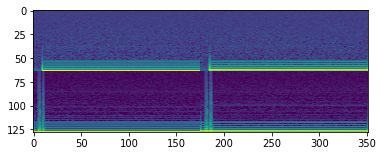

In [11]:
# 合併兩張圖成為一張很寬的圖片
plt.imshow(X_train[1].reshape(128, 176*2))
plt.show()

In [12]:
# Build model
from keras import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add( Conv2D( filters=25, kernel_size=(3,3), padding='same', activation='relu', input_shape=(128, 176*2, 1) ) )
model.add(MaxPooling2D(pool_size=(2,2)))
model.add( Flatten())
model.add( Dense( units=512, activation='relu'  ) )
model.add( Dense( units=11, activation='softmax' ) )
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 352, 25)      250       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 176, 25)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 281600)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               144179712 
_________________________________________________________________
dense_2 (Dense)              (None, 11)                5643      
Total params: 144,185,605
Trainable params: 144,185,605
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train_oh, batch_size=5, validation_split=0.1, verbose=1, epochs=25)

Train on 518 samples, validate on 58 samples
Epoch 1/25
518/518 [==============================] - 10s 20ms/step - loss: 2.2223 - accuracy: 0.2085 - val_loss: 2.2312 - val_accuracy: 0.2069
Epoch 2/25
518/518 [==============================] - 8s 16ms/step - loss: 2.2152 - accuracy: 0.2046 - val_loss: 2.2236 - val_accuracy: 0.2069
Epoch 3/25
518/518 [==============================] - 8s 16ms/step - loss: 2.1890 - accuracy: 0.2239 - val_loss: 2.2098 - val_accuracy: 0.2241
Epoch 4/25
518/518 [==============================] - 8s 16ms/step - loss: 2.1377 - accuracy: 0.2317 - val_loss: 2.1750 - val_accuracy: 0.2069
Epoch 5/25
518/518 [==============================] - 8s 16ms/step - loss: 2.0676 - accuracy: 0.3147 - val_loss: 2.0903 - val_accuracy: 0.3966
Epoch 6/25
518/518 [==============================] - 8s 16ms/step - loss: 1.9251 - accuracy: 0.3649 - val_loss: 1.9216 - val_accuracy: 0.3966
Epoch 7/25
518/518 [==============================] - 8s 16ms/step - loss: 1.7156 - accuracy: 0.

In [14]:
# 看精準度
model.evaluate(X_train, y_train_oh)[1]
# 0.9565972089767456
# 0.9635416865348816
# 0.9739583134651184
# 0.9861111044883728
# 0.9878472089767456
# 0.9895833134651184 - RMSprop

576/576 [==============================] - 0s 479us/step


0.7222222089767456

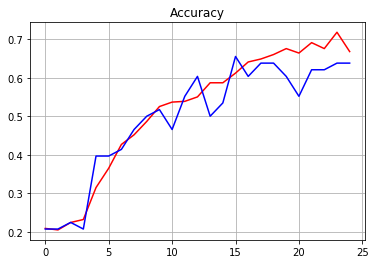

In [15]:
plt.plot(history.history['accuracy'], color='red')
plt.plot(history.history['val_accuracy'], color='blue')
plt.title('Accuracy')
plt.grid()
plt.show()

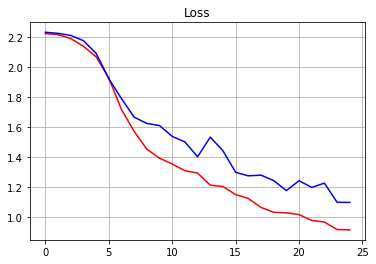

In [16]:
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.title('Loss')
plt.grid()
plt.show()

In [17]:
# prediction
y_pred= np.argmax(model.predict(X_train), axis=1)
y_pred[:10]
y_train[:10]

array([4, 9, 4, 9, 6, 3, 3, 4, 8, 3], dtype=int64)

Text(78.308, 0.5, 'True value')

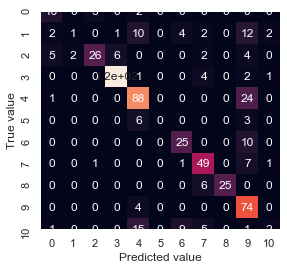

In [18]:
import seaborn as sns; sns.set() # plot formatting
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_train, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('Predicted value')
plt.ylabel('True value')

In [19]:
# 進行比賽讀入test數據 並且匯出


# X 讀取 all training data (image)
# os.walk 從作業系統中每讀取一筆檔案名稱 進行影像讀取 加上 標籤對應

image_test_c = [] # 每一的檔案的影像 電流訊號轉的影像
image_test_v = [] # 每一的檔案的影像 電壓訊號轉的影像
data_test    = [] # 每一的檔案對應appliance 數字

import os
for root, dirs, files in os.walk("./data/test/", topdown=False):
    for filename in files:
        if os.path.join(root, filename).endswith('c.png'):
            data_test.append( filename.split('_')[0] )
            file = os.path.join(root, filename)
            image_test_c.append(io.imread(file, as_gray=True))
            image_test_v.append(io.imread(file.replace('c.png', 'v.png'), as_gray=True))

In [20]:
X_test = np.hstack([np.array(image_test_c).reshape(384, 128*176).astype(np.float32)/255.0, \
                    np.array(image_test_v).reshape(384, 128*176).astype(np.float32)/255.0]).reshape(384, 128, 176*2, 1)
X_test.shape

(384, 128, 352, 1)

In [21]:
# 預測
y_test_pred = np.argmax(model.predict(X_test), axis=1)
y_test_pred

array([ 9,  4, 10,  7,  8,  6,  7,  4,  4,  9,  7,  9,  3,  3,  7,  3,  9,
        8,  7,  4,  9,  2,  3,  3,  7,  0,  0,  4,  3,  6,  4,  4,  9,  9,
        3,  4,  7,  0,  9,  0,  3,  9,  3,  3,  7,  8,  3,  2,  4,  4,  7,
        4,  4,  4,  4,  4,  3,  4,  4,  3,  3,  4,  4,  3,  4,  6,  9,  3,
        8,  6,  3,  2,  7,  3,  9,  2,  4,  0,  6,  8,  9,  0, 10,  7,  3,
        2,  0,  3,  4,  8,  3,  6,  7,  3,  9,  9,  8,  7,  4, 10,  4,  3,
        7,  1,  9,  2,  3,  4,  4,  8,  0,  6,  4,  9,  4,  4,  4,  4,  4,
        9,  6,  6,  4,  4,  3,  4,  8,  3,  4,  3,  9,  4,  7,  6,  3,  9,
       10,  4,  2,  4,  7,  4,  7,  8,  8,  3,  2,  4,  9,  4,  4,  7,  4,
        9,  9,  4,  4,  7,  0,  7,  4,  9,  3,  6,  9,  4,  4,  0,  6,  3,
        2,  4,  4,  7,  4,  9,  3,  3,  9,  4,  4,  0,  4,  2,  6,  8,  3,
        4,  9,  9,  9,  9,  2,  3,  9,  4,  0, 10,  9,  4,  3,  9,  3,  8,
        8,  4,  3,  7,  7,  4,  4,  7,  3,  8,  9,  9,  4,  4,  4,  3,  3,
        4,  3,  9,  4,  9

In [22]:
# 彙總輸出
submission = pd.DataFrame(data_test, columns=['id'])
submission['appliance'] = y_test_pred
submission.to_csv('./submission.20191228.001.csv', index=False)